# Kaggle Competition - Milestone 2

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import urllib.request

from IPython.core.interactiveshell import InteractiveShell
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [3]:
# load data
x = pickle.load(urllib.request.urlopen('https://s3.amazonaws.com/stat558drjordankaggle/train_features'))
test_set = pickle.load(urllib.request.urlopen('https://s3.amazonaws.com/stat558drjordankaggle/test_features'))
y = np.array(pickle.load(urllib.request.urlopen('https://s3.amazonaws.com/stat558drjordankaggle/train_labels')))
y = y.astype(float)

# image transformations not used for this milestone
# color_set = pickle.load(urllib.request.urlopen('https://s3.amazonaws.com/stat558drjordankaggle/color_features'))
# compress_set = pickle.load(urllib.request.urlopen('https://s3.amazonaws.com/stat558drjordankaggle/compress_features'))
# crop_set = pickle.load(urllib.request.urlopen('https://s3.amazonaws.com/stat558drjordankaggle/crop_features'))
# crop_to_corner_set = pickle.load(urllib.request.urlopen('https://s3.amazonaws.com/stat558drjordankaggle/crop_to_corner_features'))
# homography_set = pickle.load(urllib.request.urlopen('https://s3.amazonaws.com/stat558drjordankaggle/homography_features'))
# mirror_set = pickle.load(urllib.request.urlopen('https://s3.amazonaws.com/stat558drjordankaggle/mirror_features'))
# rotate30_set = pickle.load(urllib.request.urlopen('https://s3.amazonaws.com/stat558drjordankaggle/rotate30_features'))
# scale_set = pickle.load(urllib.request.urlopen('https://s3.amazonaws.com/stat558drjordankaggle/scale_features'))

In [4]:
def computeobj(beta, lamb, x, y):
    # number of observations
    n = x.shape[0]
    
    # compute objective function
    obj = (1/n)*(np.sum(np.log(1 + np.exp(-y*np.dot(x, beta))))) + lamb*np.sum(beta**2)
    
    return obj


def computegrad(beta, lamb, x, y):
    # number of observations
    n = x.shape[0]
    
    # compute gradient of objective function
    grad_beta = -(1/n)*(np.dot(x.T, y/(np.exp(y*np.dot(x, beta)) + 1))) + 2*lamb*beta
    
    return grad_beta


def backtracking(beta, lamb, x, y, eta=1, alpha=0.5, gamma=0.8, max_iter=100):
    # initialize variables
    grad_beta = computegrad(beta, lamb, x, y)
    norm_grad_beta = np.sqrt(np.sum(grad_beta**2))
    found_eta = 0
    t = 0
    
    # loop through until eta found or max iterations reached
    while found_eta == 0 and t < max_iter:
        if (computeobj(beta - eta*grad_beta, lamb, x, y) <
                computeobj(beta, lamb, x, y) - alpha*eta*norm_grad_beta**2):
            found_eta = 1
        elif t == max_iter:
            break
        else:
            eta = eta*gamma
            t += 1
    
    return eta


def fastgradalgo(beta_init, theta_init, lamb, x, y, max_iter, eps):
    # initialize variables
    beta = beta_init
    theta = theta_init
    grad_theta = computegrad(theta, lamb, x, y)
    eta_init = 1/(max(np.linalg.eigh(np.dot((1/n)*x.T, x))[0]) + lamb)
    beta_vals = [beta_init]
    t = 0
    
    # loop through until EITHER max iterations reached or threshold of epsilon reached
    while t < max_iter and np.linalg.norm(grad_theta) >  eps:
        eta = backtracking(beta, lamb, x, y, eta=eta_init)
        beta_next = theta - eta*grad_theta
        theta = beta_next + t*(beta_next - beta)/(t + 3)
        grad_theta = computegrad(theta, lamb, x, y)
        beta = beta_next
        beta_vals.append(beta)
        t += 1
        
    return beta_vals


def split_data_equal(x, y, test_set, rand_state=5, train_size=0.75):
    # split into train and test sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=train_size, random_state=rand_state, stratify=y)
    
    # center and standardize x values
    x_scaler = StandardScaler().fit(x_train)
    x_train = x_scaler.transform(x_train)
    x_test = x_scaler.transform(x_test)
    test_set = x_scaler.transform(test_set)
    
    return x_train, x_test, y_train, y_test, test_set


def train_alg(x, y, classes, lamb_list):
    # initialize betas and create list for final beta values
    beta_init = np.zeros(d)
    theta_init = np.zeros(d)
    final_betas = []
    y_values = []

    # loop through each label and perform ovr appending the final betas for each class
    for i in range(len(classes)):
        lamb = lamb_list[i]
        y_binary = copy.deepcopy(y)
        y_binary[y != classes[i]] = -1
        y_binary[y == classes[i]] = 1
        betas = fastgradalgo(beta_init=beta_init, theta_init=theta_init, lamb=lamb, x=x_train, y=y_binary, max_iter=1000, eps=1e-5)[-1]
        final_betas.append(betas)
        
    return np.array(final_betas)


def predict(x, betas, classes):
    # initialize calculated y values
    y_values = []
    
    # loop through set of final betas and calculate y values
    for i in range(len(betas)):
        y_values.append(np.dot(x, betas[i]))
    
    # calculate predicted values
    y_predict = classes[np.argmax(np.array(y_values), axis=0)]
    
    return y_predict


def accuracy_misclass_error(predict, actual):
    # calculate misclassification error
    misclass_error = np.mean(predict != actual)*100
    accuracy = 100 - misclass_error
    
    return accuracy, misclass_error


def display_confusion_matrix(predict, actual):
    # calculate confusion matrix
    conf_mat = confusion_matrix(y_true=actual, y_pred=predict)
    
    # build visual plot
    plt.matshow(conf_mat);
    plt.title('Confusion Matrix');
    plt.xlabel('Predicted Label');
    plt.ylabel('True Label');
    plt.xticks(range(len(classes)), classes);
    plt.yticks(range(len(classes)), classes);
    
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 18
    fig_size[1] = 12
    plt.rcParams["figure.figsize"] = fig_size
    
    return conf_mat
    

def class_diff(classes, conf_matrix):
    # initialize variable to append each individual class percent
    percent_correct = []
    
    # loop through confusion matrix by true label
    for i in range(len(conf_matrix[0, :])):
        class_count = np.sum(conf_matrix[i])
        misclass_count = 0
        
        # loop through confusion matrix by predict label and append percent correct
        for j in range(len(conf_matrix[:, 0])):
            if i != j:
                misclass_count += conf_matrix[i][j]
            else:
                pass
        percent_correct.append(misclass_count/class_count)
        
    # calcuate ordered list of multi-class misclassification error
    ordered_class_diff = np.vstack((classes, np.array(percent_correct))).T
    ordered_class_diff = ordered_class_diff[ordered_class_diff[:, 1].argsort()[::-1]]
    
    return ordered_class_diff
    

def decomp_PCA(train, test, test_set, explained_var_threshold=0.95):
    pca = PCA().fit(train)

    pca_explained_var_ratio = pca.explained_variance_ratio_

    pca_explained_var = []
    num_component_vectors = 0

    while np.sum(pca_explained_var) < explained_var_threshold:
        pca_explained_var.append(pca_explained_var_ratio[num_component_vectors])
        num_component_vectors += 1
    #print('# Component Vectors: %d    Explained Var: %f' % (num_component_vectors, np.sum(pca_explained_var)))

    pca = PCA(n_components=num_component_vectors).fit(train)
    x_train = pca.transform(train)
    x_test = pca.transform(test)
    test_set = pca.transform(test_set)
    
    return x_train, x_test, test_set

- Pick $k = 5$ classes of your choice from the dataset. You may choose any subset of 5 classes among all classes of the dataset.

In [5]:
# subset the data for the first five classes
classes = np.unique(y)[0:5]
index = np.ravel(np.nonzero(np.in1d(y, classes)))
x_subset = x[index]
y_subset = y[index]

- Write a function that, for any class at hand, creates a training set with an equal number of examples from the class at hand and from the other classes. You may simply randomly pick the examples from the other classes.

In [6]:
# see above "split_data_equal" function

# split data
x_train, x_test, y_train, y_test, test_set = split_data_equal(x_subset, y_subset, test_set)
n = x_train.shape[0]
d = x_train.shape[1]

- For each class _c_, train an $\ell_2^2$-regularized logistic regression classiﬁer using _your own fast gradient algorithm_ with $\lambda_c=1$. Display the confusion matrix. Which classes seem to be the most diﬃcult to classify?

In [7]:
betas = train_alg(x=x_train, y=y_train, classes=classes, lamb_list=[1, 1, 1, 1, 1])
y_predict = predict(x=x_test, betas=betas, classes=classes)
accuracy, misclass_error = accuracy_misclass_error(predict=y_predict, actual=y_test)

Compare coefficients from my own _fast gradient algorithm_ to those from scikit learn.

In [8]:
pd.DataFrame(betas)

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,-0.000394,-0.000520,0.000369,-0.008736,0.001789,-0.003680,-0.004604,-0.003171,-0.005278,-0.002190,...,0.000512,-0.007627,0.007183,0.000971,0.013051,0.002880,0.008109,-0.009810,0.004303,-0.001887
1,0.000586,0.001529,0.004743,0.012820,-0.004775,-0.000732,0.016167,0.010797,0.002612,-0.003186,...,-0.002564,0.011356,-0.005319,-0.003187,-0.006499,-0.009484,0.000241,0.015603,-0.003333,-0.003804
2,0.011003,0.002882,-0.011399,0.001417,-0.000084,-0.000513,0.003430,-0.002197,-0.004508,0.011429,...,0.002081,-0.005939,-0.005204,0.005689,0.002806,0.000785,-0.006149,0.008245,0.014035,0.003263
3,-0.014864,-0.006269,0.018245,-0.001961,0.000986,0.000688,-0.002638,-0.001666,-0.006747,-0.008210,...,-0.002895,0.010624,0.005879,-0.013033,0.004165,-0.000437,0.000303,-0.001383,-0.005296,0.003090
4,0.001524,-0.002425,-0.008089,0.001256,0.000303,0.003146,-0.009862,-0.007076,0.011734,-0.001042,...,0.008517,-0.002372,-0.001015,0.010934,-0.007737,0.009299,-0.005106,-0.005191,-0.008181,-0.004550


In [8]:
logit = LogisticRegression(C=1/(2*n*1), fit_intercept=False).fit(x_train, y_train)
pd.DataFrame(logit.coef_)

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,-0.000394,-0.000520,0.000369,-0.008736,0.001789,-0.003679,-0.004604,-0.003171,-0.005278,-0.002190,...,0.000512,-0.007628,0.007182,0.000971,0.013050,0.002880,0.008109,-0.009810,0.004303,-0.001886
1,0.000586,0.001529,0.004743,0.012820,-0.004775,-0.000732,0.016167,0.010797,0.002612,-0.003186,...,-0.002564,0.011355,-0.005319,-0.003187,-0.006499,-0.009484,0.000241,0.015603,-0.003334,-0.003804
2,0.011003,0.002882,-0.011400,0.001417,-0.000084,-0.000513,0.003430,-0.002197,-0.004508,0.011429,...,0.002081,-0.005939,-0.005204,0.005689,0.002806,0.000785,-0.006149,0.008245,0.014035,0.003263
3,-0.014864,-0.006269,0.018245,-0.001961,0.000986,0.000688,-0.002638,-0.001666,-0.006747,-0.008210,...,-0.002895,0.010624,0.005879,-0.013033,0.004165,-0.000437,0.000303,-0.001383,-0.005297,0.003090
4,0.001524,-0.002425,-0.008089,0.001256,0.000303,0.003146,-0.009862,-0.007076,0.011734,-0.001042,...,0.008517,-0.002372,-0.001015,0.010934,-0.007737,0.009299,-0.005106,-0.005191,-0.008182,-0.004550


In [9]:
print('Accuracy: %f' % (accuracy))
print('Misclassification Error: %f' % (misclass_error))

Accuracy: 86.842105
Misclassification Error: 13.157895


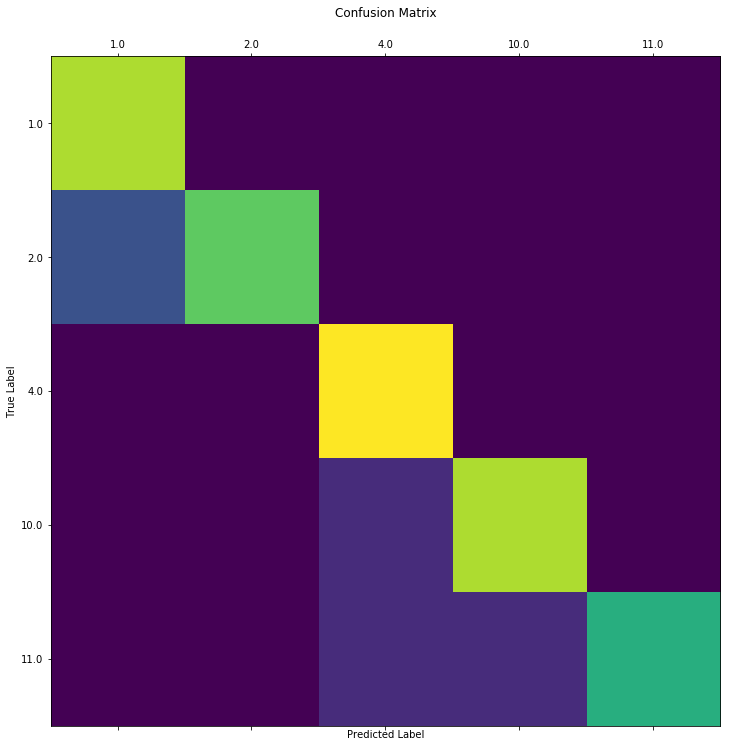

In [11]:
# calculate and display confusion matrix (see function above)
conf_mat = display_confusion_matrix(predict=y_predict, actual=y_test)

- Write a function that returns the ranked list of classes in terms of classiﬁcation diﬃculty using the confusion matrix. Compute the _multi-class misclassiﬁcation error_.

In [12]:
# see above "class_diff" function

pd.DataFrame(class_diff(classes, conf_mat), columns=['class', 'misclass error'])

,class,misclass error
0,11.0,0.285714
1,2.0,0.250000
2,10.0,0.125000
3,4.0,0.000000
4,1.0,0.000000


- Find the values of the regularization parameters $\lambda_1,\dots,\lambda_k$ for the classiﬁers using a hold-out validation set strategy. Deﬁne a grid of values $\Lambda$ for each parameter $\lambda_c$ with $c=1,\ldots,k$. For each setting of the regularization parameters $\lambda_1,\ldots,\lambda_k$, where __each__ $\lambda_c$ can take values in $\Lambda$ (independently), train all your $k=5$ classiﬁers and save the _multi-class misclassiﬁcation error_ on the validation set for each setting of the regularization parameters $\lambda_1,\ldots,\lambda_k$.

In [9]:
# declare lambdas/folds to test cv (NOTE: there are only two lambdas and three folds as this is computationally intensive)
lamb_inputs = [0.01, 0.0001]
num_folds = 3

# create a dictionary of possibilities to be fed into ParameterGrid
param_grid = {'class1':lamb_inputs,
              'class2':lamb_inputs,
              'class4':lamb_inputs,
              'class10':lamb_inputs,
              'class11':lamb_inputs}

# create a grid of all possibilities for the five classes
lamb_param_grid = ParameterGrid(param_grid)

In [14]:
# initialize variable
average_misclass_error = []

# loop through all possible lambda/class combinations
for params in lamb_param_grid:
    lamb_list = [params['class1'], params['class2'], params['class4'], params['class10'], params['class11']]
    multi_class_misclass_error = []

    # loop through folds for cross-validation
    for i in range(num_folds):
        # resplit data for each fold(1 & 2 & 3)
        x_train, x_test, y_train, y_test, test_set = split_data_equal(x_subset, y_subset, test_set, rand_state=i)

        # train algorithm and get predictions/multi-class misclassification error
        betas = train_alg(x=x_train, y=y_train, classes=classes, lamb_list=lamb_list)
        y_predict = predict(x=x_test, betas=betas, classes=classes)
        accuracy, misclass_error = accuracy_misclass_error(predict=y_predict, actual=y_test)
        multi_class_misclass_error.append(misclass_error)
        
        # append average multi-class misclassification error
        if i == num_folds - 1:
            average_misclass_error.append(np.mean(multi_class_misclass_error))
        else:
            pass

### _This is not scalable!!!_

- Find the optimal value of the regularization parameters $\lambda_1,\ldots,\lambda_k$ based on the validation error. Display the confusion matrix for this setting of the regularization parameters

In [15]:
# initialize variables
class1_lamb = []
class2_lamb = []
class4_lamb = []
class10_lamb = []
class11_lamb = []

# grab all of the lambda values for each class
for i in range(len(lamb_param_grid)):
    class1_lamb.append(lamb_param_grid[i]['class1'])
    class2_lamb.append(lamb_param_grid[i]['class2'])
    class4_lamb.append(lamb_param_grid[i]['class4'])
    class10_lamb.append(lamb_param_grid[i]['class10'])
    class11_lamb.append(lamb_param_grid[i]['class11'])

# put values into a data frame for more readable content
df = pd.DataFrame({'class1_lambda':class1_lamb,
                   'class2_lambda':class2_lamb,
                   'class4_lambda':class4_lamb,
                   'class10_lambda':class10_lamb,
                   'class11_lambda':class11_lamb,
                   'misclass_error':average_misclass_error})

# sort by lowest misclassification error to be extracted for confusion matrix
df = df.sort_values('misclass_error')
df = df.reset_index(drop=True)
df

,class10_lambda,class11_lambda,class1_lambda,class2_lambda,class4_lambda,misclass_error
0,0.0001,0.0100,0.0001,0.0001,0.0001,7.017544
1,0.0001,0.0100,0.0001,0.0001,0.0100,7.017544
2,0.0001,0.0100,0.0001,0.0100,0.0001,7.017544
3,0.0001,0.0100,0.0001,0.0100,0.0100,7.017544
4,0.0001,0.0100,0.0100,0.0100,0.0100,7.017544
5,0.0001,0.0100,0.0100,0.0100,0.0001,7.017544
6,0.0001,0.0100,0.0100,0.0001,0.0100,7.017544
7,0.0001,0.0100,0.0100,0.0001,0.0001,7.017544
8,0.0100,0.0100,0.0100,0.0100,0.0100,9.649123
9,0.0001,0.0001,0.0001,0.0100,0.0001,9.649123


Compare optimal lambdas from my own cross-validation to those from scikit learn's LogisticRegressionCV. This is not a good representative sample as there are only five classes involved and it is currently very accurate at predicting for only five classes.

In [16]:
lamb_list = np.array(df.iloc[0][0:5]).tolist()
lamb_list

[0.0001, 0.01, 0.0001, 0.0001, 0.0001]

In [17]:
logitCV = LogisticRegressionCV(fit_intercept=False).fit(x_train, y_train)
logitCV.C_

array([ 0.0001    ,  0.0001    ,  0.00077426,  0.00077426,  0.00599484])

Accuracy: 86.842105
Misclassification Error: 13.157895


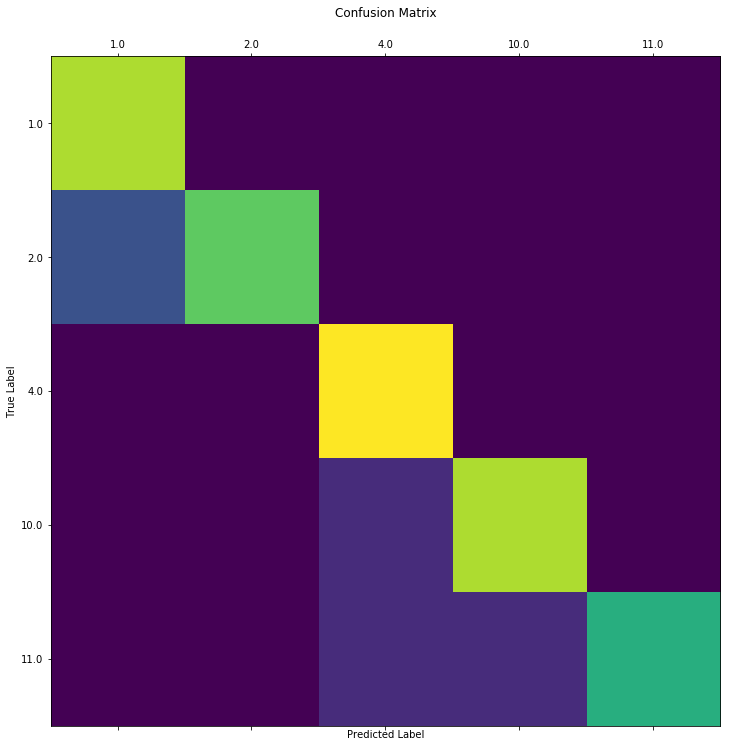

In [18]:
# reset the data to the original split (for comparison of optimal lambdas)
x_train, x_test, y_train, y_test, test_set = split_data_equal(x_subset, y_subset, test_set)

# predict using new ideal lambdas from cross-validation and show confusion matrix
betas = train_alg(x=x_train, y=y_train, classes=classes, lamb_list=lamb_list)
y_predict = predict(x=x_test, betas=betas, classes=classes)
accuracy, misclass_error = accuracy_misclass_error(predict=y_predict, actual=y_test)
print('Accuracy: %f' % (accuracy))
print('Misclassification Error: %f' % (misclass_error))
conf_mat = display_confusion_matrix(predict=y_predict, actual=y_test)

There are not any noticeable differences, however, we are unable to test an appropriate number of different lambdas, and the dataset is rather small when considering only five classes. This is not a scalable approach for a larger dataset or number of lambdas to use for cross-validation.